# Reading real flights data 

In [1]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()
from pyspark.sql import SparkSession
from pyspark.context import SparkContext 
from pyspark.sql.functions import *
spark = SparkSession.builder.getOrCreate()#create spark session 
sc = spark.sparkContext#create sparkContext
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                                DecimalType,
                                LongType,
                                ArrayType,
                                TimestampType)
sample_schema = StructType([StructField("id",  IntegerType(), True),
                            StructField("timeAtServer", DoubleType(), True),
                            StructField("aircraft",  IntegerType(), True ),
                            StructField("latitude", DoubleType(), True),
                            StructField("longitude", DoubleType(), True  ),
                            StructField("baroAltitude", DoubleType(), True ),
                            StructField("geoAltitude", DoubleType(), True ),
                            StructField("numM",IntegerType(), True),
                            StructField("measurements", StringType(), True)           
                            ])
sample_aircarft = spark.read.csv("C:/PFE/TEST/training_1_category_1.csv",
                       header = True,  
                        schema = sample_schema)
#sort our data  by distinct aircraft and time at server 
sorted_flights =sample_aircarft.orderBy('timeAtServer','aircraft')
sorted_flights.show(3)

+---+------------+--------+----------------+----------------+------------+-----------+----+--------------------+
| id|timeAtServer|aircraft|        latitude|       longitude|baroAltitude|geoAltitude|numM|        measurements|
+---+------------+--------+----------------+----------------+------------+-----------+----+--------------------+
|  2|         0.0|    1605|50.4821311821372|7.35423320048564|     10363.2|   10500.36|   5|[[463,963756980,2...|
|  1|         0.0|    1787|49.5238952636719|7.80282271535773|      6400.8|    6537.96|   3|[[463,963309455,4...|
|  3|         0.0|    2022|45.9829505015228|8.61870574951172|     11277.6|   11445.24|   3|[[14,981538828,29...|
+---+------------+--------+----------------+----------------+------------+-----------+----+--------------------+
only showing top 3 rows



# Reading correct Data

In [2]:
Result_schema = StructType([StructField("id",  IntegerType(), True),
                            StructField("latitude_r", DoubleType(), True),
                            StructField("longitude_r", DoubleType(), True  ),
                            StructField("geoAltitude-r", DoubleType(), True ),        
                            ])
Result_aircarft = spark.read.csv("C:/PFE/TEST/training_1_category_1_result.csv",
                       header = True,  
                        schema = Result_schema)
Result_aircarft.show(3)

+---+----------------+----------------+-------------+
| id|      latitude_r|     longitude_r|geoAltitude-r|
+---+----------------+----------------+-------------+
| 10|50.3593597412109|7.39444933439556|     11780.52|
| 56| 50.093559653072|6.55586861275338|     11399.52|
|168|47.2995758056641|8.51412963867188|     11529.06|
+---+----------------+----------------+-------------+
only showing top 3 rows



# Number of null values for each aircraft:

In [3]:
df = sorted_flights.join(Result_aircarft, Result_aircarft.id == sorted_flights.id ,how="inner")
df.groupBy('aircraft').count().orderBy(desc("count")).show(3)

+--------+-----+
|aircraft|count|
+--------+-----+
|    1486| 4541|
|     343| 4468|
|     842| 4441|
+--------+-----+
only showing top 3 rows



In [4]:
df.select('latitude', 'longitude','latitude_r', 'longitude_r').show(5)

+--------+---------+----------------+----------------+
|latitude|longitude|      latitude_r|     longitude_r|
+--------+---------+----------------+----------------+
|    null|     null|50.3593597412109|7.39444933439556|
|    null|     null| 50.093559653072|6.55586861275338|
|    null|     null|47.2995758056641|8.51412963867188|
|    null|     null|47.4388732910156|8.16421508789063|
|    null|     null| 50.359791901152|7.39268534892314|
+--------+---------+----------------+----------------+
only showing top 5 rows



In [5]:
sorted_flights.filter('aircraft=276').count()

3005

# let's test our model in flight 276

In [6]:
trip276=sorted_flights.filter('aircraft=276').select('id','timeAtServer',  'latitude', 'longitude')
trip276.show(3)

+------+----------------+----------------+----------------+
|    id|    timeAtServer|        latitude|       longitude|
+------+----------------+----------------+----------------+
|685300|1226.42900013924|47.8158983133607|15.9081326998197|
|691822|1237.40900015831|47.8091482388771| 15.882075383113|
|702289|1255.27700018883|47.7981619107521|15.8398907001202|
+------+----------------+----------------+----------------+
only showing top 3 rows



# let's plot our trip :

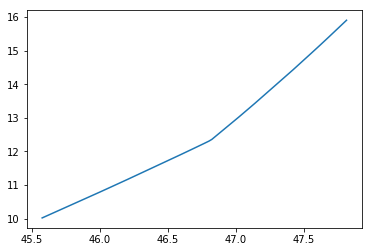

In [7]:
import plotly.graph_objs as go
import pandas as pd
import requests
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
trip276_pandas_DataFrame = pd.DataFrame.from_records(trip276.collect(), columns=trip276.columns)
plt.plot(trip276_pandas_DataFrame['latitude'], trip276_pandas_DataFrame['longitude'])

# Create fake data to test our model :
### null values each 20rd raw start from 0 :150 null positions 

In [8]:
#  i used itertuples because it's faster than  iterrows.
for row in trip276_pandas_DataFrame.itertuples():
    if row.Index  % 20 == 0:
        trip276_pandas_DataFrame.at[row.Index, 'latitude'] = None
        trip276_pandas_DataFrame.at[row.Index, 'longitude'] = None
    else:
        trip276_pandas_DataFrame.at[row.Index, 'latitude'] = trip276_pandas_DataFrame.loc[row.Index,'latitude'] 
        trip276_pandas_DataFrame.at[row.Index, 'longitude'] = trip276_pandas_DataFrame.loc[row.Index,'longitude']
        
trip276_test=trip276_pandas_DataFrame .iloc[1:,:] 
trip276_test.iloc[18:21,:]   


,id,timeAtServer,latitude,longitude
19,719055,1284.135,47.780045,15.770050
20,719657,1285.181,NaN,NaN
21,720266,1286.240,47.778717,15.764969


In [9]:
trip276_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004 entries, 1 to 3004
Data columns (total 4 columns):
id              3004 non-null int64
timeAtServer    3004 non-null float64
latitude        2854 non-null float64
longitude       2854 non-null float64
dtypes: float64(3), int64(1)
memory usage: 94.0 KB


# Transform our pandas_dataframe to spark_dataframe:

In [10]:
spark276_test = spark.createDataFrame(trip276_test)
spark276_test.show(20)

+------+----------------+----------------+----------------+
|    id|    timeAtServer|        latitude|       longitude|
+------+----------------+----------------+----------------+
|691822|1237.40900015831|47.8091482388771| 15.882075383113|
|702289|1255.27700018883|47.7981619107521|15.8398907001202|
|703553|1257.38300013542|47.7968584480932|15.8348905123197|
|704118|1258.36400008202|47.7962493896484|15.8326034545898|
|704364|1258.79200005531|47.7959739555747|15.8315101036659|
|706166|1261.93799996376|47.7940521240234|15.8240203857422|
|707016|1263.35899996758|47.7931342690678|15.8205942007212|
|707260|1263.76999998093|47.7929077148438|15.8196258544922|
|709019|1266.61800003052|47.7910859706038|15.8127065805288|
|709292|1267.08500003815|47.7908066571769|15.8115797776442|
|709558|1267.54800009727|  47.79052734375|15.8104934692383|
|711015|1270.00100016594|47.7889709472656|15.8045196533203|
|711648|1271.08500003815|47.7882928363347|15.8018611027644|
|714996|1277.16499996185|47.784429000595

In [11]:
spark276_test.filter((col("latitude") == "NaN") ).count()
print("numbers of null values :"+ str(spark276_test.filter((col("latitude") == "NaN") ).count()))

numbers of null values :150


# Spark Window Function - PySpark
Window (also, windowing or windowed) functions perform a calculation over a set of rows. It is an important tool to do statistics. Most Databases support Window functions. Spark from version 1.4 start supporting Window functions.

Spark Window Functions have the following traits:

   - perform a calculation over a group of rows, called the Frame.
   - a frame corresponding to the current row
   - return a new value to for each row by an aggregate/window function
   - Can use SQL grammar or DataFrame API.
### Basic Frame with partitionBy
### Ordered Frame with partitionBy and orderBy
###  lag & lead in a group

-lag and lead can be used, when we want to get a relative result between rows. The real values we get are depending on the order.

-lag means getting the value from the previous row; lead means getting the value from the next row.

In [12]:
from pyspark.sql import functions as F
from pyspark.sql.window import Window
#in case of all trips we must use:my_window = Window.partitionBy('aircaft').orderBy("timeAtServer")
my_window = Window.partitionBy().orderBy("timeAtServer")
spark276_test= spark276_test.withColumn("lat_prev", F.lag(spark276_test.latitude).over(my_window))
spark276_test= spark276_test.withColumn("long_prev", F.lag(spark276_test.longitude).over(my_window))
spark276_test= spark276_test.withColumn("T_prev", F.lag(spark276_test.timeAtServer).over(my_window))
spark276_test=spark276_test.withColumn('∆T',spark276_test.timeAtServer-spark276_test.T_prev)
spark276_test.show(3)

+------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+
|    id|    timeAtServer|        latitude|       longitude|        lat_prev|       long_prev|          T_prev|               ∆T|
+------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+
|691822|1237.40900015831|47.8091482388771| 15.882075383113|            null|            null|            null|             null|
|702289|1255.27700018883|47.7981619107521|15.8398907001202|47.8091482388771| 15.882075383113|1237.40900015831|17.86800003052008|
|703553|1257.38300013542|47.7968584480932|15.8348905123197|47.7981619107521|15.8398907001202|1255.27700018883|2.105999946589918|
+------+----------------+----------------+----------------+----------------+----------------+----------------+-----------------+
only showing top 3 rows



# Navigation on "estimate"  Process
 Two cases will arise:
 
-the aircraft speed is imposed
-The arrival time is imposed

THE ELEMENTS OF NAVIGATION ON ESTIMATE:

- Starting;
- The road joining the two points;
- the speed of the airplane.
- timeatserver.

#### Let's calculate distance between  each reported point and cumulative distance .
#### calcul Velocity of our aircraft V,  Bearing 
## Formula to Find Bearing or Heading angle between two points. 
Bearing or heading angle is used to define navigation generally in the field of aircraft or marine
or Vehicle navigation or while working for land surveying.

So what’s the heading or bearing?

How we can find bearing between the two points on earth, with the formula? 

Or How we can find the other point, when one point, actual traveled distance and bearing is given?

==> Bearing can be defined as direction or an angle, between the north-south line of earth or meridian 
and the line connecting the target and the reference point. 
While Heading is an angle or direction where you are currently navigating in. 
This means to reach a particular destination you need to adjust your heading direction with the bearing. 


Let us look on formula and tool for bearing:

    Let ‘R’ be the radius of Earth,
    ‘L’ be the longitude,
    ‘θ’ be latitude,
    ‘β‘ be Bearing.
    
Denote point A and B as two different points, where ‘La’ is point A longitude and ‘θa’ is point A latitude,
similarly assume for point B. 
Bearing would be measured from North direction i.e 0° bearing means North, 90° bearing is East,
180° bearing is measured to be South, and 270° to be West.

Note: If bearing is denoted with +ve or –ve initials whose values lies between 0° to 180°,
then –ve is denoted for South and West sides.
Formula to find Bearing, when two different points latitude, longitude is given:

Bearing from point A to B, can be calculated as,

β = atan2(X,Y),

where, X and Y are two quantities and can be calculated as:

X = cos θb * sin ∆L

Y = cos θa * sin θb – sin θa * cos θb * cos ∆L

In [13]:
import geohash2
import pyspark.sql.functions as F
from pyspark.sql.functions import udf,col
from pyspark.sql.types import IntegerType
from pyspark.sql.types import *
from pyspark.sql.functions import udf
import pandas as pd
from math import radians, cos, sin, asin, sqrt

from geopy.geocoders import Nominatim
from math import radians, cos, sin, asin, sqrt, atan2, degrees



def get_distance_3d(distance_2d, alt1, alt2): 
    distance_3d = sqrt(distance_2d**2+(alt2-alt1)**2)
    return  distance_3d
def get_Difference( alt1, alt2): 
    Difference= alt1-alt2
    return Difference

udf_get_distance_3d = F.udf(get_distance_3d)
udf_get_Difference = F.udf(get_Difference)

def initial_bearing(lat1,long1,lat2,long2):
    if lat1==None and long1==None:
        compass_bearing=None
    else:
        lat1 = radians(float(lat1))
        lat2 = radians(float(lat2))

        diffLong = radians(float(long2) - float(long1))

        x = sin(diffLong) * cos(lat2)
        y = cos(lat1) * sin(lat2) - (sin(lat1)
            * cos(lat2) * cos(diffLong))

        initial_bearing = atan2(x, y)

         # Now we have the initial bearing but math.atan2 return values
         # from -180° to + 180° which is not what we want for a compass bearing
         # The solution is to normalize the initial bearing as shown below
        initial_bearing = degrees(initial_bearing)
        
        compass_bearing = (initial_bearing + 360) % 360
        if  compass_bearing ==0:       
                compass_bearing=360
        else:
                compass_bearing=compass_bearing
    return compass_bearing 
udf_initial_bearing = F.udf(initial_bearing)
spark276_test = spark276_test.withColumn('bearing', lit(None).cast(DoubleType()))
spark276_test=spark276_test.withColumn('bearing',
       when(( col("lat_prev")=='null')& (col('long_prev')=='null'),udf_initial_bearing('lat_prev','long_prev','latitude','longitude').cast(DoubleType()))                                 
      .when((col("latitude")!="NaN")& (col('longitude')!="NaN")&( col("lat_prev")!="NaN")& (col('long_prev')!="NaN"),udf_initial_bearing('lat_prev','long_prev','latitude','longitude').cast(DoubleType()))                              
      .otherwise(F.mean(spark276_test.bearing).over(my_window.rowsBetween(-3,-1)).cast(DoubleType())))
spark276_test=spark276_test.withColumn('BE',
       when(( spark276_test.bearing!='null')|(spark276_test.bearing!="NaN"),spark276_test.bearing)                                                             
      .otherwise(F.mean(spark276_test.bearing).over(my_window.rowsBetween(-3,-1)).cast(DoubleType())))                              
spark276_test.select('lat_prev','long_prev','latitude','longitude','bearing','BE').show(22)   

+----------------+----------------+----------------+----------------+------------------+------------------+
|        lat_prev|       long_prev|        latitude|       longitude|           bearing|                BE|
+----------------+----------------+----------------+----------------+------------------+------------------+
|            null|            null|47.8091482388771| 15.882075383113|              null|              null|
|47.8091482388771| 15.882075383113|47.7981619107521|15.8398907001202|248.82236435551917|248.82236435551917|
|47.7981619107521|15.8398907001202|47.7968584480932|15.8348905123197|248.79243634244216|248.79243634244216|
|47.7968584480932|15.8348905123197|47.7962493896484|15.8326034545898|  248.376083638797|  248.376083638797|
|47.7962493896484|15.8326034545898|47.7959739555747|15.8315101036659|249.44411427861007|249.44411427861007|
|47.7959739555747|15.8315101036659|47.7940521240234|15.8240203857422|249.09784555150588|249.09784555150588|
|47.7940521240234|15.8240203

# Distance en km 

In [14]:
import numpy as np
from geopy.distance import geodesic
def get_distance_2d(lat_1, lng_1, lat_2, lng_2): 
    A =(lat_1, lng_1)
    B = (lat_2, lng_2)
    try:
        return geodesic(A, B).kilometers
    except ValueError:
        return np.nan 
udf_get_distance_2d = F.udf(get_distance_2d)
spark276_test=spark276_test.withColumn('Delta_D',udf_get_distance_2d('lat_prev','long_prev','latitude','longitude').cast(DoubleType()))                         
spark276_test=spark276_test.withColumn('DE',
       when((spark276_test.Delta_D!="NaN"),spark276_test.Delta_D)                                                             
      .otherwise(F.mean(spark276_test.Delta_D).over(my_window.rowsBetween(-3,-1)).cast(DoubleType()))) 
spark276_test=spark276_test.withColumn('DE_F',
       when((spark276_test.DE!="NaN"),spark276_test.DE)                                                             
      .otherwise(F.mean(spark276_test.DE).over(my_window.rowsBetween(-3,-1)).cast(DoubleType()))) 
spark276_test.select('lat_prev','latitude','BE','Delta_D','DE_F').show(22)


+----------------+----------------+------------------+-------------------+-------------------+
|        lat_prev|        latitude|                BE|            Delta_D|               DE_F|
+----------------+----------------+------------------+-------------------+-------------------+
|            null|47.8091482388771|              null|  5515.828909350934|  5515.828909350934|
|47.8091482388771|47.7981619107521|248.82236435551917| 3.3878563154525545| 3.3878563154525545|
|47.7981619107521|47.7968584480932|248.79243634244216|  0.401656622979104|  0.401656622979104|
|47.7968584480932|47.7962493896484|  248.376083638797|0.18423922932419087|0.18423922932419087|
|47.7962493896484|47.7959739555747|249.44411427861007|0.08745024919607133|0.08745024919607133|
|47.7959739555747|47.7940521240234|249.09784555150588|  0.600441866362994|  0.600441866362994|
|47.7940521240234|47.7931342690678|248.26070408033803| 0.2762406660818728| 0.2762406660818728|
|47.7931342690678|47.7929077148438|250.79954791441

# Cumulative Distance/ Time  of our trip :

In [15]:
spark276_test=spark276_test.withColumn('D_cumu',F.sum('DE_F').over(my_window)-5515.828909350934)
spark276_test=spark276_test.withColumn('T_cumu',F.sum('∆T').over(my_window))
spark276_test.select('timeAtServer', 'DE_F','D_cumu', '∆T','T_cumu').show(22)

+----------------+-------------------+------------------+------------------+------------------+
|    timeAtServer|               DE_F|            D_cumu|                ∆T|            T_cumu|
+----------------+-------------------+------------------+------------------+------------------+
|1237.40900015831|  5515.828909350934|               0.0|              null|              null|
|1255.27700018883| 3.3878563154525545|3.3878563154521544| 17.86800003052008| 17.86800003052008|
|1257.38300013542|  0.401656622979104|3.7895129384314714| 2.105999946589918|19.973999977109997|
|1258.36400008202|0.18423922932419087| 3.973752167755265|  0.98099994660015|20.954999923710147|
|1258.79200005531|0.08745024919607133| 4.061202416951346|0.4279999732898432| 21.38299989699999|
|1261.93799996376|  0.600441866362994| 4.661644283314672| 3.145999908449994|24.528999805449985|
|1263.35899996758| 0.2762406660818728| 4.937884949396903|1.4210000038201542| 25.94999980927014|
|1263.76999998093|0.07680025640407391| 5

# Velocity  :
#### - velocity km per hour km/h ,of our aircraft :

In [16]:
spark276_test=spark276_test.withColumn('V',(spark276_test.DE_F*3600)/col('∆T'))
spark276_test.select('DE_F','D_cumu','∆T','V','BE').show(22)

+-------------------+------------------+------------------+------------------+------------------+
|               DE_F|            D_cumu|                ∆T|                 V|                BE|
+-------------------+------------------+------------------+------------------+------------------+
|  5515.828909350934|               0.0|              null|              null|              null|
| 3.3878563154525545|3.3878563154521544| 17.86800003052008| 682.5768253188324|248.82236435551917|
|  0.401656622979104|3.7895129384314714| 2.105999946589918| 686.5925353256115|248.79243634244216|
|0.18423922932419087| 3.973752167755265|  0.98099994660015| 676.1073003783034|  248.376083638797|
|0.08745024919607133| 4.061202416951346|0.4279999732898432| 735.5628896094787|249.44411427861007|
|  0.600441866362994| 4.661644283314672| 3.145999908449994| 687.0917933280471|249.09784555150588|
| 0.2762406660818728| 4.937884949396903|1.4210000038201542| 699.8356053633091|248.26070408033803|
|0.07680025640407391

# process of predicting our missed Localisations 
For our porject let's  find a lat lon point, when bearing, distance and another lat lon is given.

Let us assume a condition, where you want to find  where will an Airplane will land up, 
if you have following details of that Airplane, i.e actual distance it will travel, 
the bearing and the starting point (lat,lon)?

    Let first point latitude be la1,
    longitude as lo1,
    d be distance,
    R as radius of Earth,
    Ad be the angular distance i.e d/R and
    θ be the bearing,

Here is the formula to find the second point, when first point, bearing and distance is known:

   -latitude of second point = la2 =  **asin(sin la1 * cos Ad  + cos la1 * sin Ad * cos θ)**, 
   
   -longitude  of second point = lo2 = **lo1 + atan2(sin θ * sin Ad * cos la1 , cos Ad – sin la1 * sin la2)**
    
**If we dont have  distance , let's calculat it d= ∆T*V** 

**First point  la1=lat_prev lon1=long_prev**



# 1-First method

In [17]:

def getEndlat2(lat1,lon1,bearing,d):
    if lat1==None and long1==None:
        lat2=None
    else:
        R = 6378.1                   #Radius of the Earth
        brng = math.radians(bearing) #convert degrees to radians
         #distance to km
        lat2 = math.asin( math.sin(lat1)*math.cos(d/R) + math.cos(lat1)*math.sin(d/R)*math.cos(brng))
       
        return lat2
def getEndlon2(lat1,lon1,bearing,d):
    if lat1==None and long1==None:
        long2=None
    else:
        R = 6378.1                   #Radius of the Earth
        brng = math.radians(bearing) #convert degrees to radians
         #distance to km
        lat2 = math.asin( math.sin(lat1)*math.cos(d/R) + math.cos(lat1)*math.sin(d/R)*math.cos(brng))
        lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),math.cos(d/R)-math.sin(lat1)*math.sin(lat2))
       
        return  lon2

# 2-second method 
-let's calculate **d= t_delta*V**, we have calculated it in each reported point= __DE_F__

-First point  **A(la1=lat_prev, lon1=long_prev)**

-Estimate our point **B** not detected by the __ABS-D__

In [18]:
import geopy
from geopy.distance import geodesic
from geographiclib.geodesic import Geodesic
import math
geod = Geodesic.WGS84  # define the WGS84 ellipsoid
# given: lat1, lon1, b = bearing in degrees, d = distance in kilometers
def getEndlat2(lat1,lon1,bearing,d):
    if lat1==None and lon1==None:
        lat2=None
    else:
        geod = Geodesic.WGS84  # define the WGS84 ellipsoid
        g = geod.Direct(lat1, lon1, bearing, d*1000)
        lat2 = g['lat2']
        return lat2

def getEndlon2(lat1,lon1,bearing,d):
    if lat1==None and lon1==None:
        lon2=None
    else:
        geod = Geodesic.WGS84  # define the WGS84 ellipsoid
        geod = Geodesic.WGS84
        g = geod.Direct(lat1, lon1, bearing, d*1000)
        lon2 = g['lon2']
        return lon2
udf_getEndlat2 = F.udf(getEndlat2)
udf_getEndlon2= F.udf(getEndlon2)
spark276_test=spark276_test.withColumn('lat_pred', udf_getEndlat2('lat_prev','long_prev','BE','DE_F'))
spark276_test=spark276_test.withColumn('lon_pred', udf_getEndlon2('lat_prev','long_prev','BE','DE_F'))
spark276_test.select('latitude','longitude','lat_pred','lon_pred').show(5)

+----------------+----------------+------------------+------------------+
|        latitude|       longitude|          lat_pred|          lon_pred|
+----------------+----------------+------------------+------------------+
|47.8091482388771| 15.882075383113|              null|              null|
|47.7981619107521|15.8398907001202|47.798132869858975|15.839907400233482|
|47.7968584480932|15.8348905123197|47.796855002182795|15.834892494100758|
|47.7962493896484|15.8326034545898| 47.79624778855492| 15.83260439518318|
|47.7959739555747|15.8315101036659| 47.79597322102153| 15.83151051186241|
+----------------+----------------+------------------+------------------+
only showing top 5 rows



# Distance_erreur 
-We will calculate the error distance from real localisation and predicted localisation :

In [19]:
spark276_test=spark276_test.filter((col('latitude')=='NaN')|(col("longitude") == "NaN")).select('id','lat_pred','lon_pred')
spark276_test.show(5)

+------+------------------+------------------+
|    id|          lat_pred|          lon_pred|
+------+------------------+------------------+
|719657| 47.77878762856287|15.765092202702881|
|734020| 47.76335811805109| 15.70580022227288|
|744566| 47.75281241999871|15.665570749763061|
|767958| 47.72478126654803| 15.55873252675025|
|782657|47.707595462397336|15.491301658320433|
+------+------------------+------------------+
only showing top 5 rows



In [20]:
trip276_T= sorted_flights.join(spark276_test,on=['id'], how="inner")
trip276_T=trip276_T.withColumn('D_erreur', udf_get_distance_2d('latitude','longitude','lat_pred','lon_pred').cast(DoubleType()))
trip276_T.select('id','latitude','longitude','lat_pred','lon_pred','D_erreur').show(5)

+-------+----------------+----------------+------------------+------------------+--------------------+
|     id|        latitude|       longitude|          lat_pred|          lon_pred|            D_erreur|
+-------+----------------+----------------+------------------+------------------+--------------------+
|1411439|46.9120866161282|12.6485032301683|  46.9121485467635|12.648784993392308|0.022542002890834332|
|1950699|45.8389178777145|10.4960632324219| 45.83891649495746|10.496041881670793|0.001665797565482...|
|1087360|47.3405456542969|14.1376190185547| 47.34036637290629| 14.13684598243949|0.061726225812603064|
|1596318|46.5783070709746|11.8738861083984|46.577424982675254|11.872166845847314| 0.16426356144154475|
|1682794|46.4021999553099|11.5392837524414|46.402189910187325|11.539285707405133|0.001126682552680...|
+-------+----------------+----------------+------------------+------------------+--------------------+
only showing top 5 rows



# Descriptive/Quantile statistics  of Distance erreur:

In [21]:
trip276_T_pandas_DataFrame = pd.DataFrame.from_records(trip276_T.collect(), columns=trip276_T.columns)
trip276_T_pandas_DataFrame['D_erreur'].describe()

count    150.000000
mean       0.100699
std        0.120469
min        0.000300
25%        0.019578
50%        0.060632
75%        0.133207
max        0.687446
Name: D_erreur, dtype: float64

# Plot real filght 276 Blue  logo-predicted  localisation Red logo  

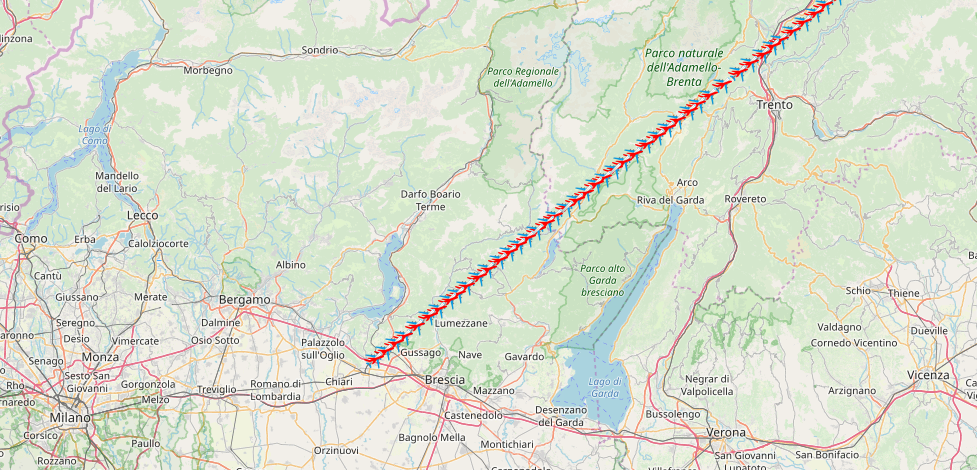
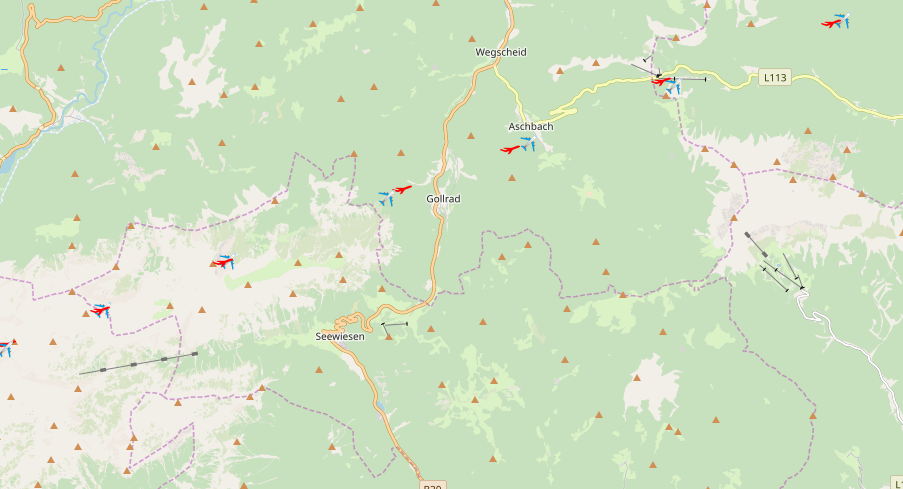

In [23]:
trip276_T_pandas_DataFrame.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 0 to 149
Data columns (total 12 columns):
id              150 non-null int64
timeAtServer    150 non-null float64
aircraft        150 non-null int64
latitude        150 non-null float64
longitude       150 non-null float64
baroAltitude    150 non-null float64
geoAltitude     150 non-null float64
numM            150 non-null int64
measurements    150 non-null object
lat_pred        150 non-null object
lon_pred        150 non-null object
D_erreur        150 non-null float64
dtypes: float64(6), int64(3), object(3)
memory usage: 15.2+ KB


# Evaluation Regression metrics
## 1-Explained variance score

-The explained_variance_score computes the explained variance regression score.

-lat_pred is the estimated target output, latitude is the corresponding (correct) target output.

-The best possible score is 1.0, lower values are worse


In [24]:
A_true = trip276_T_pandas_DataFrame[['latitude','longitude']].apply(list, axis=0)
Lat_true = trip276_T_pandas_DataFrame['latitude']
A_pred=trip276_T_pandas_DataFrame[['lat_pred','lon_pred']].apply(list, axis=0)
Lat_pred=trip276_T_pandas_DataFrame['lat_pred']
A_true[0:3]

,latitude,longitude
0,46.912087,12.648503
1,45.838918,10.496063
2,47.340546,14.137619


In [25]:
>>> from sklearn.metrics import explained_variance_score
#explained score for lat and lat_predicted
>>> explained_variance_score(Lat_true, Lat_pred)  

0.999998889460489

In [38]:
##explained score for (both lat, lng )and (lat_predicted,long_predicted)
>>> explained_variance_score(A_true, A_pred, multioutput='raw_values')

array([0.99999889, 0.9999988 ])

# 2. Mean absolute error
-The mean_absolute_error function computes mean absolute error.

-A risk metric corresponding to the expected value of the absolute error loss or L1-norm loss.

In [40]:
>>> from sklearn.metrics import mean_absolute_error
>>> mean_absolute_error(A_true, A_pred)

0.0007835006871389479

# 3. Mean squared error
-The mean_squared_error function computes mean square error.

-A risk metric corresponding to the expected value of the squared (quadratic) error or loss.

In [42]:
>>> from sklearn.metrics import mean_squared_error
>>> mean_squared_error(A_true,  A_pred)

1.8681724571720674e-06

# 4. Median absolute error
-The median_absolute_error is particularly interesting because it is robust to outliers.

-The loss is calculated by taking the median of all absolute differences between the target and the prediction.

In [46]:
>>> from sklearn.metrics import median_absolute_error
#lets calculate it for latitude 
>>> median_absolute_error(Lat_true, Lat_pred)

0.0002649301453949704

# 5. Mean squared logarithmic error
The mean_squared_log_error function computes a risk metric corresponding to the expected value of the squared logarithmic (quadratic) error or loss.

In [43]:
>>> from sklearn.metrics import mean_squared_log_error

>>> mean_squared_log_error(A_true,  A_pred) 

7.877273096138588e-09

# 6. R² score, the coefficient of determination
The r2_score function computes the coefficient of determination, usually denoted as R².

It represents the proportion of variance (of y) that has been explained by the independent variables in the model.

It provides an indication of goodness of fit .

And therefore a measure of how well unseen samples are likely to be predicted by the model, 
through the proportion of explained variance.

As such variance is dataset dependent, R² may not be meaningfully comparable across different datasets.
Best possible score is 1.0 and it can be negative (because the model can be arbitrarily worse). 
A constant model that always predicts the expected value of y, disregarding the input features, would get a R² score of 0.0.

In [48]:
>>> from sklearn.metrics import r2_score
>>> r2_score(A_true, A_pred)  

0.9999988355984335